In [2]:
import os
import sys
import tensorflow as tf
import numpy as np
import math
import skimage
import cv2

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras import Model
from skimage.measure import compare_ssim as ssim

%matplotlib inline

In [3]:
# to solve the issue of gpu memory lock
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#------------------------------------------#

In [98]:
# helper functions

# function to calculate the peak signal to noise ratio of low resolution and high resolution
def psnr(l_res, h_res):
    
    # convert the image data to floats
    l_resData = l_res.astype(float)
    h_resData = h_res.astype(float)
    
    # calculate the difference
    diff = h_resData - l_resData
    diff = diff.flatten('C')
    
    # calculate the root mean square difference
    rmsd = math.sqrt(np.mean(diff ** 2.))
    
    # calculate the psnr
    psnr = 20 * math.log10(255. / rmsd)
    
    return psnr

# function for mean squared error
def mse(l_res, h_res):
    
    # sum of squared differences of two images
    error = np.sum((l_res.astype(float) - h_res.astype(float)) ** 2)
    
    # divide by total number of pixels
    error /= float(l_res.shape[0] * h_res.shape[1])
    return error

# compare the qulity of low-res and high-res images
def compare_images(l_res, h_res):
    
    results = []
    results.append(psnr(l_res, h_res))
    results.append(mse(l_res, h_res))
    results.append(ssim(l_res, h_res, multichannel=True))
    
    return results


# degrade images

def degrade_images(path, value):
    
    # for all the files in the given path
    for file in os.listdir(path):
        
        # read the file using cv2
        img = cv2.imread(path + '/' + file)
        
        # find the old and new image dimensions
        h, w, c = img.shape
        new_h = int(h / value)
        new_w = int(h / value)
        
        # downsize the image
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        
        # upsize the image
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('Test_degrded/{}'.format(file), img) 
        
        
# image pre processing
def size_mod(img, factor):
    temp_size = img.shape
    size = temp_size[0:2]
    size = size - np.mod(size, factor)
    return img[0:size[0], 1:size[1]]


def crop(img, edge):
    return img[edge:-edge, edge:-edge]        
        
    
    
def test(test_path):
    
    model = srcnn_model()
    model.load_weights('epoch55_100.h5')
    
    # load high res and and low res images
    path, file = os.path.split(test_path)
    lr = cv2.imread(test_path)
    hr = cv2.imread('Test/{}'.format(file))
    
    # take the mode of the images
    lr = size_mod(lr, 3)
    hr = size_mod(hr, 3)
    
    # convert the images to YCrCb color space
    ycrcb = cv2.cvtColor(lr, cv2.COLOR_BGR2YCrCb)
    
    # extract the Y (luminance) channel from YCrCb space
    Y = np.zeros((1, ycrcb.shape[0], ycrcb.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = ycrcb[:, :, 0].astype(float) / 255
    
    # make a prediction using trained model
    prediction = model.predict(Y, batch_size=1)
    
    # post procces the images
    prediction *= 255
    prediction[prediction > 255] = 255
    prediction[prediction < 0] = 0
    prediction = prediction.astype(np.uint8)

    # reconstruct the image in BGR space
    # note the predicted image lost the 4 pixels on each side therefore we need the crop
    # the image with a factor of 4
    ycrcb = crop(ycrcb, 4)
    ycrcb[:, :, 0] = prediction[0, :, :, 0] 
    recon_image = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    
    # remove the border of the lr and hr image for comparison
    lr = crop(lr.astype(np.uint8), 4)
    hr = crop(hr.astype(np.uint8), 4)
    
    # image comparison
    metrics = []
    metrics.append(compare_images(lr, hr))
    metrics.append(compare_images(recon_image, hr))
    
    # return hr, lr, reconstructed image and metrics
    return hr, lr, recon_image, metrics

In [93]:
# image pre processing, split to f*f patches, extract Luminance channel and prepare train data labels

PATCH_SIZE = 32
STRIDE = 14
FACTOR = 2

def image_split(path):
    
    x_train = []
    y_train = []
    for i, file in enumerate(os.listdir(path)):
        
        # read the file using cv2
        hr = cv2.imread(path + '/' + file)
        
        # find the old and new image dimensions
        h, w, c = hr.shape
        
        # change the image color channel to YCrCb
        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2YCrCb)
        hr = hr[:, :, 0]
       
        
        
        
        # degrade the images by downsizing and upsizing
        new_h = int(h / FACTOR)
        new_w = int(w / FACTOR) 
        lr = cv2.resize(hr, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        lr = cv2.resize(lr, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # number of stride steps
        w_steps = int((w -(PATCH_SIZE - STRIDE)) / STRIDE)
        h_steps = int((h -(PATCH_SIZE - STRIDE)) / STRIDE)
        
        #print('w: {}'.format(w))
        #print('h: {}'.format(h))
        #print('w_steps: {}'.format(w_steps))
        #print('h_steps: {}'.format(h_steps))
        
        hr = hr.astype(float) / 255
        lr = lr.astype(float) / 255
        
        for i in range(w_steps):
            for j in range(h_steps):
                
                hr_patch = hr[j * STRIDE: j * STRIDE + PATCH_SIZE , i * STRIDE: i * STRIDE + PATCH_SIZE]
                lr_patch = lr[j * STRIDE: j * STRIDE + PATCH_SIZE , i * STRIDE: i * STRIDE + PATCH_SIZE]
                
                if hr_patch.shape[0] == hr_patch.shape[1]:
                    x_train.append(lr_patch)
                    y_train.append(crop(hr_patch, 4)) 
                    
    x_train = np.array(x_train, dtype=float)
    y_train = np.array(y_train, dtype=float)
    
    return x_train[...,np.newaxis], y_train[...,np.newaxis]

In [16]:
degrade_images('Test/', 2)

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving bridge.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving man.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp


In [27]:
# compare the image quality metrics

for img in os.listdir('Test_degrded/'):
    
    lr = cv2.imread('Test_degrded/{}'.format(img))
    hr = cv2.imread('Test/{}'.format(img))
    
    # calculate the metrics
    metrics = compare_images(lr, hr)
    
    print(lr.shape)
    
    # print the results
    #print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(img, metrics[0], metrics[1], metrics[2]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


(480, 500, 3)
(512, 512, 3)
(576, 720, 3)
(288, 288, 3)
(512, 512, 3)
(256, 256, 3)
(288, 352, 3)
(361, 250, 3)
(276, 276, 3)
(362, 500, 3)
(288, 352, 3)
(280, 280, 3)
(512, 512, 3)
(512, 512, 3)
(512, 768, 3)
(512, 512, 3)
(656, 529, 3)
(344, 228, 3)
(391, 586, 3)


In [7]:
# build the SRCNN model

def srcnn_model():
    inputs = tf.keras.Input(shape=(None, None, 1))
    x = Conv2D(128, (9, 9), padding='valid', activation='relu',
               kernel_initializer='glorot_uniform', use_bias=True)(inputs)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_initializer='glorot_uniform', use_bias=True)(x)
    
    outputs = Conv2D(1, (5, 5), padding='same', activation='linear',
               kernel_initializer='glorot_uniform', use_bias=True)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='SRCNN')
    
    # define loss and optimizer
    optimizer = tf.keras.optimizers.Adam(lr=0.0003)
    
    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model
    

In [23]:
my_model2 = srcnn_model()
my_model.summary()

Model: "SRCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [94]:
# get the training 
x_train, y_train = image_split('Train/')


In [95]:
print('Size:\n Training data: {}\n Training Labels: {}\n'.format(x_train.shape, y_train.shape))

Size:
 Training data: (22227, 32, 32, 1)
 Training Labels: (22227, 24, 24, 1)



In [ ]:
data 

In [100]:
history = my_model2.fit(x_train, y_train, epochs=200, batch_size=64)

Epoch 1/200
348/348 [==============================] - 1s 4ms/step - loss: 8.8100e-04 - mean_squared_error: 8.8099e-04
Epoch 2/200
348/348 [==============================] - 1s 4ms/step - loss: 8.8133e-04 - mean_squared_error: 8.8133e-04
Epoch 3/200
348/348 [==============================] - 1s 4ms/step - loss: 8.8076e-04 - mean_squared_error: 8.8076e-04
Epoch 4/200
348/348 [==============================] - 1s 4ms/step - loss: 8.7997e-04 - mean_squared_error: 8.7997e-04
Epoch 5/200
348/348 [==============================] - 1s 4ms/step - loss: 8.7864e-04 - mean_squared_error: 8.7864e-04
Epoch 6/200
348/348 [==============================] - 1s 4ms/step - loss: 8.7951e-04 - mean_squared_error: 8.7951e-04
Epoch 7/200
348/348 [==============================] - 1s 4ms/step - loss: 8.7930e-04 - mean_squared_error: 8.7930e-04
Epoch 8/200
348/348 [==============================] - 1s 4ms/step - loss: 8.7805e-04 - mean_squared_error: 8.7805e-04
Epoch 9/200
348/348 [===========================

348/348 [==============================] - 1s 4ms/step - loss: 8.5043e-04 - mean_squared_error: 8.5043e-04
Epoch 70/200
348/348 [==============================] - 1s 4ms/step - loss: 8.5044e-04 - mean_squared_error: 8.5044e-04
Epoch 71/200
348/348 [==============================] - 1s 4ms/step - loss: 8.4987e-04 - mean_squared_error: 8.4987e-04
Epoch 72/200
348/348 [==============================] - 1s 4ms/step - loss: 8.4959e-04 - mean_squared_error: 8.4959e-04
Epoch 73/200
348/348 [==============================] - 1s 4ms/step - loss: 8.4997e-04 - mean_squared_error: 8.4997e-04
Epoch 74/200
348/348 [==============================] - 1s 4ms/step - loss: 8.4831e-04 - mean_squared_error: 8.4831e-04
Epoch 75/200
348/348 [==============================] - 1s 4ms/step - loss: 8.4924e-04 - mean_squared_error: 8.4924e-04
Epoch 76/200
348/348 [==============================] - 1s 4ms/step - loss: 8.4655e-04 - mean_squared_error: 8.4655e-04
Epoch 77/200
348/348 [==============================]

348/348 [==============================] - 1s 4ms/step - loss: 8.3117e-04 - mean_squared_error: 8.3117e-04
Epoch 138/200
348/348 [==============================] - 1s 4ms/step - loss: 8.3231e-04 - mean_squared_error: 8.3231e-04
Epoch 139/200
348/348 [==============================] - 1s 4ms/step - loss: 8.3107e-04 - mean_squared_error: 8.3107e-04
Epoch 140/200
348/348 [==============================] - 1s 4ms/step - loss: 8.3142e-04 - mean_squared_error: 8.3142e-04
Epoch 141/200
348/348 [==============================] - 1s 4ms/step - loss: 8.3108e-04 - mean_squared_error: 8.3108e-04
Epoch 142/200
348/348 [==============================] - 1s 4ms/step - loss: 8.2989e-04 - mean_squared_error: 8.2989e-04
Epoch 143/200
348/348 [==============================] - 1s 4ms/step - loss: 8.3089e-04 - mean_squared_error: 8.3089e-04
Epoch 144/200
348/348 [==============================] - 1s 4ms/step - loss: 8.3009e-04 - mean_squared_error: 8.3009e-04
Epoch 145/200
348/348 [=======================

In [103]:
my_model2.save_weights('epoch55_100.h5', save_format="h5")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 24.736019115843245
MSE: 655.5407656100853
SSIM: 0.8787386836168255

Reconstructed Image: 
PSNR: 29.73051160148031
MSE: 207.5632467660709
SSIM: 0.948413175510847



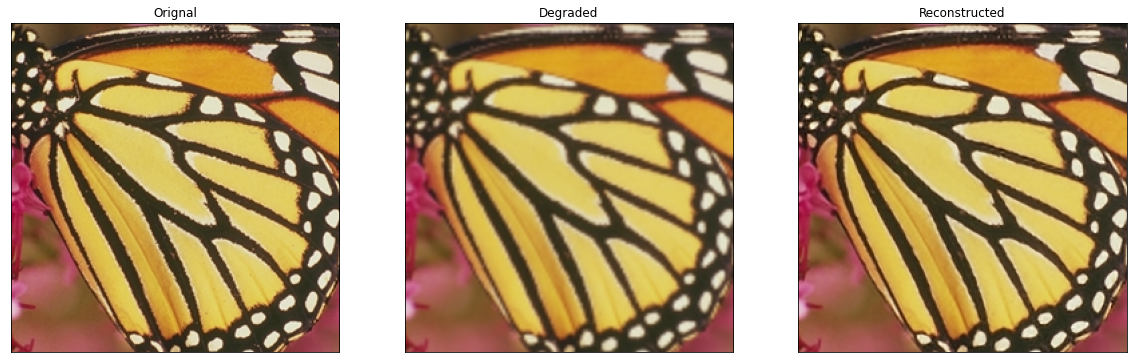

In [106]:
hr, lr, result, metrics = test('Test_degrded/butterfly_GT.bmp')

# compare the quality of images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(metrics[0][0], metrics[0][1], metrics[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(metrics[1][0], metrics[1][1], metrics[1][2]))

# display images side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(hr, cv2.COLOR_BGR2RGB))
axs[0].set_title('Orignal')
axs[1].imshow(cv2.cvtColor(lr, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axs[2].set_title('Reconstructed')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

Degraded Image: 
PSNR: 26.111921094612867
MSE: 477.5397262502324
SSIM: 0.8365852042491504

Reconstructed Image: 
PSNR: 24.810651961607192
MSE: 644.3716420338353
SSIM: 0.776805221044469

In [ ]:
path = 'Train/'

data = []
labels = []
for i, file in enumerate(os.listdir(path)):
        
        # read the file using cv2
        img = cv2.imread(path + '/' + file)
        
        # find the old and new image dimensions
        h, w, c = img.shape
        
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        #print(ycrcb.shape)
        # extract the Y (luminance) channel from YCrCb space
        Y = np.zeros((ycrcb.shape[0], ycrcb.shape[1], 1), dtype=float)
        Y[:, :, 0] = ycrcb[:, :, 0].astype(float) / 255
        if i == 0:
            Y2 = Y
            
        print(Y.shape)
        data.append(Y2)
        ycrcb = crop(ycrcb, 4)
        Y = np.zeros((ycrcb.shape[0], ycrcb.shape[1], 1), dtype=float)
        Y[:, :, 0] = ycrcb[:, :, 0].astype(float) / 255
        if i == 0:
            Y3 = Y
        labels.append(Y3)
        print('{} h: {} w: {} c: {} \n'.format(file, h, w, c))
        
data = np.array(data, dtype=float)
labels = np.array(labels, dtype=float)

In [ ]:

    #print(ycrcb.shape)
        # extract the Y (luminance) channel from YCrCb space
        Y = np.zeros((ycrcb.shape[0], ycrcb.shape[1], 1), dtype=float)
        Y[:, :, 0] = ycrcb[:, :, 0].astype(float) / 255
        if i == 0:
            Y2 = Y
            
        print(Y.shape)
        data.append(Y2)
        ycrcb = crop(ycrcb, 4)
        Y = np.zeros((ycrcb.shape[0], ycrcb.shape[1], 1), dtype=float)
        Y[:, :, 0] = ycrcb[:, :, 0].astype(float) / 255
        if i == 0:
            Y3 = Y
        labels.append(Y3)
        print('{} h: {} w: {} c: {} \n'.format(file, h, w, c))